In [1]:
import Pkg
Pkg.activate("./")

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`


In [1]:
using Random, Statistics, Plots, LaTeXStrings, DifferentialEquations, LinearAlgebra, BackAction, Base.Threads, Test

In [2]:
delta_gammelmark = 0.2/0.478 * [0.146,0.262,0.383,0.511,0.648,0.806,0.965,1.118,1.287,1.438,1.596,
                                1.755,1.888, 2.057, 2.206, 2.381, 2.539, 2.682, 2.865, 3.013, 3.174, 3.334, 3.452]
fi_t_gammelmark = [0.115, 0.221, 0.338, 0.425, 0.507, 0.557, 0.573, 0.566, 0.532, 0.494,
                   0.448, 0.403, 0.363, 0.318, 0.281, 0.241, 0.210, 0.186, 0.156, 0.137, 0.115, 0.101, 0.09348];

In [3]:
# Set up the unravelings
function sample_c2(seed)
    theta = pi*rand()
    phi = 2*pi*rand()
    return [cos(theta*0.5); exp(1im*phi)*sin(theta*0.5)] 
end
function get_random_unraveling(seed)
    Random.seed!(seed)
    T = sample_c2(seed) 
    T = reshape(T/norm(T), 2,1)
    T_curvy = [real(T[1]) imag(T[1]); real(T[2]) imag(T[2]) ]
    F = svd(T_curvy) # Factorization object
    P = F.V * Diagonal(F.S) * F.Vt
    O = F.U * F.Vt
    T_curvy_dyne = O' * T_curvy
    T_dyne = O' * real.(T) + 1im * O' * imag.(T)
    Ta = T 
    Tb = T_dyne 
    Tc = T_dyne 
    Ts = Dict([("a", Ta), ("b", Tb), ("c", Tc)]) # Dictionary with the Ts
    alpha0 = [0.5 + 0im; 0.5 + 0im] 
    alphas = Dict([("a", alpha0), ("b", alpha0), ("c", O' * alpha0)]) # Dictionary with the alphas

    return Ts, alphas
end


get_random_unraveling (generic function with 1 method)

In [5]:
# Base parametric operators
function H0(delta::Float64, omega::Float64, k::Float64)::Matrix{ComplexF64}

    return delta*[[0, 0] [0, 1.0+0im]]  + 0.5*omega*BackAction.sigma_x
end 

function L0(delta::Float64, omega::Float64, k::Float64)::Matrix{ComplexF64}
    return sqrt(k)*BackAction.sigma_m
end 
# Unraveling parametrix operators
function obtain_parametric_unraveling_operators(T, alpha)
    # First do the unitary mixing 
    Ls_mixed = BackAction.isometric_mixing([L0], T, 2)
    H = BackAction.add_cfield_hamiltonian_correctionterm(H0, Ls_mixed, alpha, 2)
    Ls_mixed_cfield = BackAction.add_cfields(Ls_mixed, alpha, 2)
    He = BackAction.get_Heff(H, Ls_mixed_cfield, 2)
    return Ls_mixed_cfield, H, He
end


obtain_parametric_unraveling_operators (generic function with 1 method)

In [4]:
function GetFI( params::SimulParameters{T1, T2, T3},  fi_samples::Array{T2}, delta::T2, omega::T2=1.0, k::T2=0.5;
        T::Matrix{T1} = reshape([1.0 + 0im], 1,1),
        alpha::Vector{T1} = [0.0 + 0im])::Tuple{T2, T2} where {T1<:Complex, T2<:Real, T3<:Int}
# System and parameters
    Ls, H, He = obtain_parametric_unraveling_operators(T, alpha)
    sys = System(H(delta, omega, k), # Hamiltonian
                 [L(delta, omega, k) for L in Ls], # jump
                )
    sim = get_sol_jumps(sys, params,  (0.0, params.tf); save_on=false);
    # Process the jumptimes to put it in terms of increments rather than absolute times
    for n in 1:params.ntraj
        for i in 0:length(sim[n].prob.kwargs[:callback].affect!.jump_times)-2
                sim[n].prob.kwargs[:callback].affect!.jump_times[end - i] = sim[n].prob.kwargs[:callback].affect!.jump_times[end-i] - sim[n].prob.kwargs[:callback].affect!.jump_times[end-i-1]
        end
    end
    
     @threads for n in 1:params.ntraj
       
       fi_sample[n] = real(tr(monitoringoperator([tf], sys, He, Ls,
                                                    sim[n].prob.kwargs[:callback].affect!.jump_times,
                                                    sim[n].prob.kwargs[:callback].affect!.jump_channels,
                                                   params.psi0,[delta, omega, k], [delta/100, 0.0, 0.0]))^2)/params.tf
    end
    return mean(filter(!isnan, fi_sample)), std(filter(!isnan, fi_sample))
end

GetFI (generic function with 3 methods)

In [ ]:
tf = 300.0
ntraj = 1000

NLEVELS = 2

params = SimulParameters(BackAction.rf_psi0,
                            tf, # Final time. Set very long so that all trajectories jump
                            1, # seed
                            ntraj, # Number of trajectories
                            30_000, # Number of samples in the finegrid
                            1.0, # Multiplier to use in the fine grid
                            1e-3 # Tolerance for passing Dark state test
                            )
NLEVELS = 2
ntimes = 1
fi_sample = Array{Float64}(undef, params.ntraj)


rs = [1.0, 1.5, 2.0] # norm of the thing cfield

nrs = length(rs)

ndeltas = length(delta_gammelmark)
nphis = 5

phis = [ (m/nphis) * 2*pi  for m in 1:nphis]

myfis_gammelmarkdeltas = zeros(Float64, ndeltas, nphis, nrs)
myfis_gammelmarkdeltas_stds = zeros(Float64, ndeltas, nphis, nrs)



@time begin
    for k in 1:nrs
        for m in 1:nphis
            println("phi = $(phis[m])")
            for n in 1:ndeltas
                 myfis_gammelmarkdeltas[n, m, k], myfis_gammelmarkdeltas_stds[n, m, k] = GetFI(params, fi_sample, delta_gammelmark[n];
                                                                                                    alpha = [rs[k]*exp(1im*phis[m])])
            end 
        end 
    end
end 

phi = 1.2566370614359172


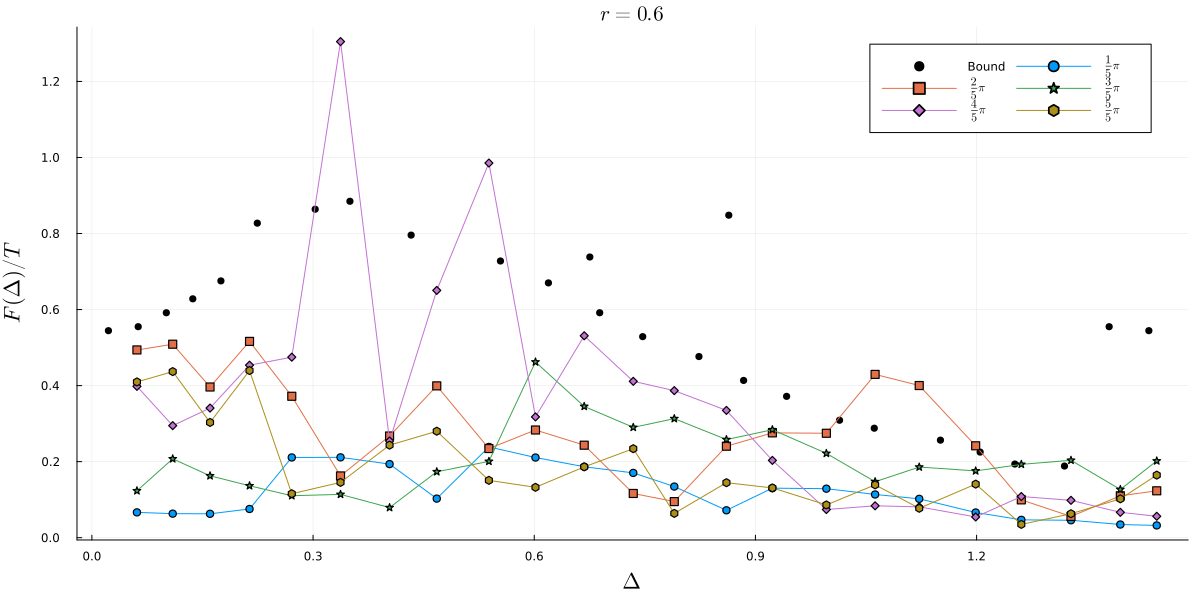

In [128]:
k = 3 # Choose the r
p = scatter(x_bound, y_bound, color = "black", label="Bound", 
            xlabel=L"\Delta", ylabel=L"F(\Delta)/T", labelfontsize=15, title=L"r=%$(rs[k])",
            left_margin=5*Plots.mm, bottom_margin=5*Plots.mm
)
shapes = [:circle
 :rect
 :star5
 :diamond
 :hexagon]
for m in 1:nphis
    #scatter!(delta_gammelmark, myfis_gammelmarkdeltas[:, m], yerr = 2.576*myfis_gammelmarkdeltas_stds[:, m]./sqrt(params.ntraj), color=m, label="$m")
    plot!(delta_gammelmark, myfis_gammelmarkdeltas[:, m, k], color=m, markershape=shapes[m], label=L"\frac{%$m}{%$nphis}\pi")
end 
plot!(size=(1200,600), legendcolumns=2)
savefig(p, "FI_phi.pdf")
p

In [16]:
y_bound = [ 0.5549738219895288 ,0.5445026178010471 ,0.5916230366492147 ,0.6282722513089005 ,0.675392670157068
    ,0.7382198952879582 ,0.8272251308900525 ,0.8638743455497383 ,0.8848167539267017 ,0.8481675392670157 ,0.7958115183246074 ,
    0.7277486910994765 ,0.6701570680628273 ,0.5916230366492147 ,0.5287958115183247 ,0.47643979057591623 ,0.4136125654450262 ,
    0.3717277486910995 ,0.3089005235602094 ,0.2879581151832461 ,0.25654450261780104 ,0.22513089005235604 ,0.193717277486911 ,0.18848167539267016]

x_bound = [0.06282051282051282, 0.022435897435897433,0.10096153846153845, 0.13685897435897434, 0.175, 0.675392670157068,
0.22435897435897434, 
0.30288461538461536, 
0.35, 0.8638743455497383,
0.4330128205128205,
0.5541666666666666,
0.6192307692307691,
0.6887820512820513,
0.7471153846153845,
0.8233974358974359,
0.8839743589743589,
0.9423076923076923,
1.014102564102564, 
1.0612179487179487,
1.1509615384615384,
1.2048076923076922,
1.251923076923077, 
1.3192307692307692,
1.3798076923076923,
1.433653846153846]

26-element Vector{Float64}:
 0.06282051282051282
 0.022435897435897433
 0.10096153846153845
 0.13685897435897434
 0.175
 0.675392670157068
 0.22435897435897434
 0.30288461538461536
 0.35
 0.8638743455497383
 0.4330128205128205
 0.5541666666666666
 0.6192307692307691
 0.6887820512820513
 0.7471153846153845
 0.8233974358974359
 0.8839743589743589
 0.9423076923076923
 1.014102564102564
 1.0612179487179487
 1.1509615384615384
 1.2048076923076922
 1.251923076923077
 1.3192307692307692
 1.3798076923076923
 1.433653846153846